Następujący program:
- przetwarza zaciągnięte dane oraz pokazuje podstawowe statystyki
- wykorzystuje: funkcje wbudowane, funkcje własne, listy, słowniki, wykresy liniowe, histogram, box
- wykorzystuje uczenie maszynowe do przewidywania zachowania giełdy
Aby dane były jakkolwiek poprawnie przewidywane, niezbędne będzie pobranie wartości akcji sprzed minimum dwóchch lat!\
importowanie niezbędnych bibliotek:

In [ ]:
import numpy as np
import pandas_datareader.data as pdr
from pandas_datareader._utils import RemoteDataError
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import json

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 8

utworzenie zmiennych typu datetime do przechowania zakresu czasu

In [ ]:
date = [2021, 1, 1]  # podanie przez użytkownika daty od której mają być pobrane dane (rok, miesiąc, dzień)
end_time = dt.datetime.now()  # aktualny czas
start_time = dt.datetime(date[0], date[1], date[2])  # czas początkowy
time_data = (start_time, end_time,
             start_time - end_time)  # krotka przechowującaa informacje o czasie (czas początkowy, aktualny czas, różnica)
json_file_path = "config.json"  # ścieżka do pliku konfiguracyjnego

zaĹ‚adowanie pliku JSON do dict'a config

In [ ]:
with open(json_file_path) as json_file:
    config = json.load(json_file)

moĹĽliwe jest teĹĽ odczytanie z pliku z wykorzystaniem przygotowanej funkcji get_stock_data_from_file(file_path)

funkcja wykorzystujÄ…ca biblioteki tensorflow do utworzenia modelu ML oraz przewidywanie

In [ ]:
def predict_stock_moves_ML(stock_input_array):
    try:
        # możliwe jest przekazanie tylko jednej akcji na raz!!!
        data = stock_input_array.filter(['Close'])  # filtrowanie data frame w celu uzyskania tylko kolumny Close
        dataset = data.values  # konwersja na np.array
        # wykorzystanie 80% danych do uczenia maszynowego (nie ma sensu więcej)
        training_data_len = math.ceil(len(dataset) * .8)
        # normalizacja danych z wykorzystaniem MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)
        # przygotowanie danych do trenowania modelu
        train_data = scaled_data[0:training_data_len, :]
        x_train = []
        y_train = []
        for i in range(60, len(train_data)):
            x_train.append(train_data[i - 60:i, 0])
            y_train.append(train_data[i, 0])
        # konwersja x_train oraz y_train na np
        x_train, y_train = np.array(x_train), np.array(y_train)
        # przygotowanie macierzy trójwymiarowej (wymagane przez silnik neuronowy LSTM)
        print(f"Aktualna wielkość danych treningowych wynosi {x_train.shape[0]}x{x_train.shape[1]}")
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        # budowanie modelu
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))
        # kompilowanie modelu
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        # trenowanie modelu
        model.fit(x_train, y_train, batch_size=1, epochs=15)
        model_output_path = config['model_path']
        model.save(model_output_path, save_format='tf')
        # utworzenie danych do testowania
        test_data = scaled_data[training_data_len - 60:, :]
        # utworzenie x_test oraz y_test
        x_test = []
        y_test = dataset[training_data_len:, :]
        for i in range(60, len(test_data)):
            x_test.append(test_data[i - 60:i, 0])
        # konwersja x_test na np
        x_test = np.array(x_test)
        # przygotowanie macierzy trójwymiarowej (wymagane przez silnik neuronowy LSTM)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        # przewidywanie
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        # uzyskiwanie RMSE - Root Mean Square Error (jest standardowym sposobem pomiaru błędu modelu w przewidywaniu danych ilościowych)
        RMSE = np.sqrt(np.mean(predictions - y_test) ** 2)
        print(f"Współczynnik RMSE wynosi: {RMSE}")
        train = data[:training_data_len]
        valid = data[training_data_len:]
        valid['Predictions'] = predictions
        output = (train, valid)
        return output
    except Exception as e:
        print(f'Exception message: {e}')

funkcja wizualizujÄ…ca przewidywane dane

In [ ]:
def visualize_predicted_data(train, valid, save_to_files, count, current_stock_name):
    try:
        plt.figure()
        plt.title(current_stock_name + " ML Predicitions")
        plt.xlabel('Date')
        plt.ylabel('Close price')
        plt.plot(train['Close'])
        plt.plot(valid[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        if save_to_files:
            file_name = "graph" + str(count) + ".png"
            plt.savefig(file_name)
            count += 1
        return count
    except Exception as e:
        print(f'Exception message: {e}')

pobieranie danych z wykorzystaniem API z Yahoo Finances

In [ ]:
def get_data_from_yahoo(stock_input_array):
    try:
        stock_data = pdr.get_data_yahoo(stock_input_array, start_time, end_time)
        return stock_data
    except RemoteDataError as e:
        file_path_temp = config['stockFilePath']
        print(f'No data found for {file_path_temp}. Exception message: {e}')
        print(f"Check your internet connection or firewall settings!")

pobieranie danych z pliku txt

In [ ]:
def get_stock_data_from_file(file_path):
    try:
        lines_object = open(file_path, "r")
        lines = lines_object.read().splitlines()
        lines_object.close()
        return lines
    except RemoteDataError as e:
        print(f'An error occured while trying to read {file_path}. Error message: {e}')

wizualizacja wszystkich akcji na jednym wykresie

In [ ]:
def show_graphs(input_data_frame, save_to_files, count):
    try:
        input_data_frame = input_data_frame.Close
        input_data_frame.plot()
        if save_to_files:
            file_name = "graph" + str(count) + ".png"
            plt.savefig(file_name)
            count += 1
        input_data_frame.plot.box()
        if save_to_files:
            file_name = "graph" + str(count) + ".png"
            plt.savefig(file_name)
            count += 1
        input_data_frame.plot.area(stacked=False)
        if save_to_files:
            file_name = "graph" + str(count) + ".png"
            plt.savefig(file_name)
            count += 1
        plt.legend(loc='lower right')
        plt.show()
        return count
    except Exception as e:
        print(f'Exception message: {e}')

In [ ]:
def main():
    # pobieranie danych z Yahoo Finances
    stocks = get_stock_data_from_file(config['stockFilePath'])
    counter = 0
    data_frame = get_data_from_yahoo(stocks)
    # Przygotowywanie wizualizacji pobranych danych
    counter = show_graphs(data_frame, bool(config['performGraphSave']), counter)
    for stock in stocks:
        data_frame = get_data_from_yahoo(stock)
        # Wizualizacja przewidywanego zachowania gieĹ‚dy na 60 dni do przodu
        train, valid = predict_stock_moves_ML(data_frame)
        counter = visualize_predicted_data(train, valid, bool(config['performGraphSave']), counter, stock)
        # Wyświetlenie wykresów
        plt.show()
        counter += 1

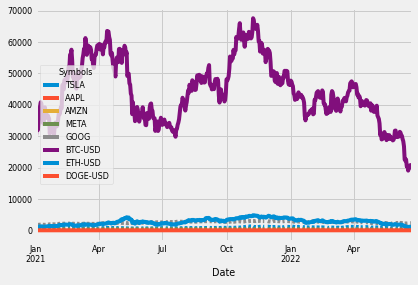

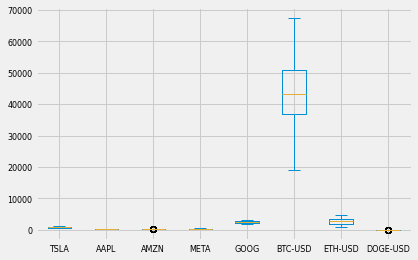

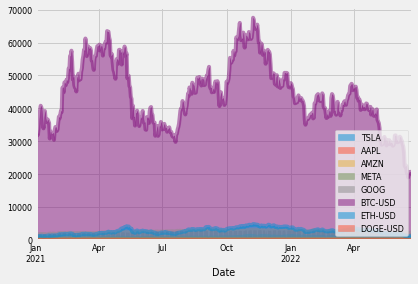

Aktualna wielkość danych treningowych wynosi 237x60
Epoch 1/15
237/237 [==============================] - 5s 13ms/step - loss: 0.0205 - accuracy: 0.0042
Epoch 2/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0094 - accuracy: 0.0042
Epoch 3/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0071 - accuracy: 0.0042
Epoch 4/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0061 - accuracy: 0.0042
Epoch 5/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0048 - accuracy: 0.0042
Epoch 6/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0038 - accuracy: 0.0042
Epoch 7/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0056 - accuracy: 0.0042
Epoch 8/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0043 - accuracy: 0.0042
Epoch 9/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0035 - accuracy: 0.0042
Epoch 10/15
237/237 [==================

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


3/3 [==============================] - 1s 6ms/step
Współczynnik RMSE wynosi: 22.0217565588049


C:\Users\kacyk\AppData\Local\Temp\ipykernel_22040\3987125901.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


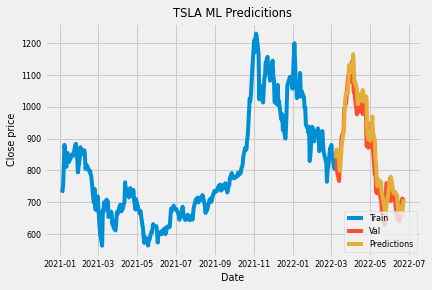

Aktualna wielkość danych treningowych wynosi 237x60
Epoch 1/15
237/237 [==============================] - 5s 13ms/step - loss: 0.0155 - accuracy: 0.0042
Epoch 2/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0080 - accuracy: 0.0042
Epoch 3/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0058 - accuracy: 0.0042
Epoch 4/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0041 - accuracy: 0.0042
Epoch 5/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0039 - accuracy: 0.0042
Epoch 6/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0036 - accuracy: 0.0042
Epoch 7/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0034 - accuracy: 0.0042
Epoch 8/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0036 - accuracy: 0.0042
Epoch 9/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0032 - accuracy: 0.0042
Epoch 10/15
237/237 [==================

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


3/3 [==============================] - 1s 6ms/step
Współczynnik RMSE wynosi: 0.7634669123469172


C:\Users\kacyk\AppData\Local\Temp\ipykernel_22040\3987125901.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


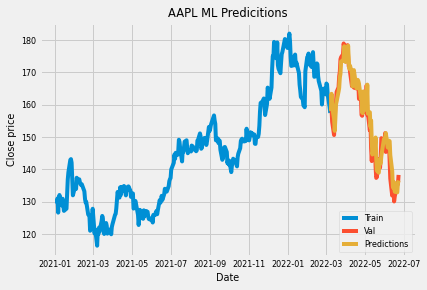

Aktualna wielkość danych treningowych wynosi 237x60
Epoch 1/15
237/237 [==============================] - 5s 12ms/step - loss: 0.0171 - accuracy: 0.0042
Epoch 2/15
237/237 [==============================] - 3s 11ms/step - loss: 0.0079 - accuracy: 0.0042
Epoch 3/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0059 - accuracy: 0.0042
Epoch 4/15
237/237 [==============================] - 3s 11ms/step - loss: 0.0047 - accuracy: 0.0042
Epoch 5/15
237/237 [==============================] - 3s 11ms/step - loss: 0.0048 - accuracy: 0.0042
Epoch 6/15
237/237 [==============================] - 3s 11ms/step - loss: 0.0041 - accuracy: 0.0042
Epoch 7/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0035 - accuracy: 0.0042
Epoch 8/15
237/237 [==============================] - 3s 11ms/step - loss: 0.0033 - accuracy: 0.0042
Epoch 9/15
237/237 [==============================] - 3s 11ms/step - loss: 0.0029 - accuracy: 0.0042
Epoch 10/15
237/237 [==================

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


3/3 [==============================] - 1s 9ms/step
Współczynnik RMSE wynosi: 3.763752911541913


C:\Users\kacyk\AppData\Local\Temp\ipykernel_22040\3987125901.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


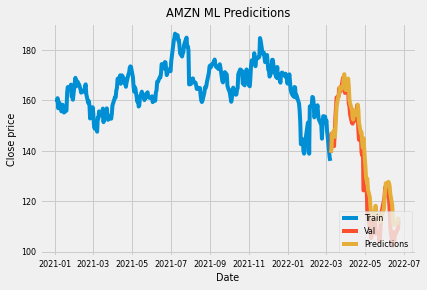

Aktualna wielkość danych treningowych wynosi 237x60
Epoch 1/15
237/237 [==============================] - 5s 13ms/step - loss: 0.0150 - accuracy: 0.0042
Epoch 2/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0064 - accuracy: 0.0042
Epoch 3/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0052 - accuracy: 0.0042
Epoch 4/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0042 - accuracy: 0.0042
Epoch 5/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0039 - accuracy: 0.0042
Epoch 6/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0039 - accuracy: 0.0042
Epoch 7/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0030 - accuracy: 0.0042
Epoch 8/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0032 - accuracy: 0.0042
Epoch 9/15
237/237 [==============================] - 3s 13ms/step - loss: 0.0030 - accuracy: 0.0042
Epoch 10/15
237/237 [==================

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


3/3 [==============================] - 1s 8ms/step
Współczynnik RMSE wynosi: 4.274227657833615


C:\Users\kacyk\AppData\Local\Temp\ipykernel_22040\3987125901.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


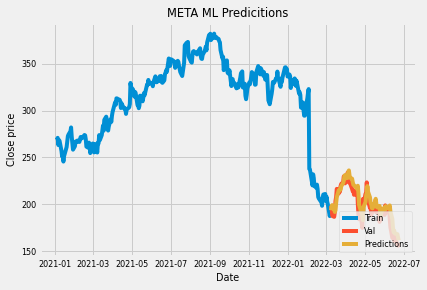

Aktualna wielkość danych treningowych wynosi 237x60
Epoch 1/15
237/237 [==============================] - 5s 12ms/step - loss: 0.0189 - accuracy: 0.0042
Epoch 2/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0051 - accuracy: 0.0042
Epoch 3/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0043 - accuracy: 0.0042
Epoch 4/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0038 - accuracy: 0.0042
Epoch 5/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0041 - accuracy: 0.0042
Epoch 6/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0035 - accuracy: 0.0042
Epoch 7/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0033 - accuracy: 0.0042
Epoch 8/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0038 - accuracy: 0.0042
Epoch 9/15
237/237 [==============================] - 3s 12ms/step - loss: 0.0028 - accuracy: 0.0042
Epoch 10/15
237/237 [==================

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


3/3 [==============================] - 1s 8ms/step
Współczynnik RMSE wynosi: 9.37608543602196


C:\Users\kacyk\AppData\Local\Temp\ipykernel_22040\3987125901.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


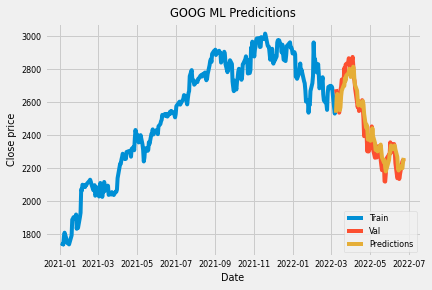

Aktualna wielkość danych treningowych wynosi 372x60
Epoch 1/15
372/372 [==============================] - 6s 13ms/step - loss: 0.0145 - accuracy: 0.0027
Epoch 2/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0061 - accuracy: 0.0027
Epoch 3/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0039 - accuracy: 0.0027
Epoch 4/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0035 - accuracy: 0.0027
Epoch 5/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0026 - accuracy: 0.0027
Epoch 6/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0025 - accuracy: 0.0027
Epoch 7/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0025 - accuracy: 0.0027
Epoch 8/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0020 - accuracy: 0.0027
Epoch 9/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0021 - accuracy: 0.0027
Epoch 10/15
372/372 [==================

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


4/4 [==============================] - 1s 10ms/step
Współczynnik RMSE wynosi: 595.1991457359813


C:\Users\kacyk\AppData\Local\Temp\ipykernel_22040\3987125901.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


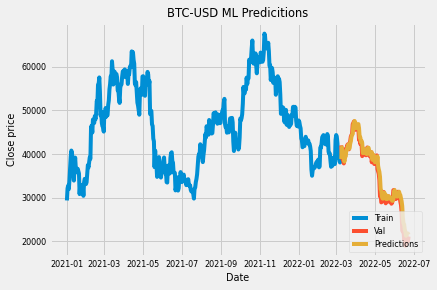

Aktualna wielkość danych treningowych wynosi 372x60
Epoch 1/15
372/372 [==============================] - 7s 14ms/step - loss: 0.0118 - accuracy: 0.0027
Epoch 2/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0049 - accuracy: 0.0027
Epoch 3/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0042 - accuracy: 0.0027
Epoch 4/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0030 - accuracy: 0.0027
Epoch 5/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0027 - accuracy: 0.0027
Epoch 6/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0029 - accuracy: 0.0027
Epoch 7/15
372/372 [==============================] - 4s 12ms/step - loss: 0.0024 - accuracy: 0.0027
Epoch 8/15
372/372 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 0.0027
Epoch 9/15
372/372 [==============================] - 5s 12ms/step - loss: 0.0020 - accuracy: 0.0027
Epoch 10/15
372/372 [==================

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


4/4 [==============================] - 1s 8ms/step
Współczynnik RMSE wynosi: 128.661458523474


C:\Users\kacyk\AppData\Local\Temp\ipykernel_22040\3987125901.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


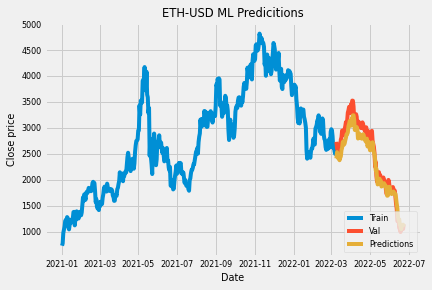

Aktualna wielkość danych treningowych wynosi 372x60
Epoch 1/15
372/372 [==============================] - 7s 13ms/step - loss: 0.0075 - accuracy: 0.0000e+00
Epoch 2/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0057 - accuracy: 0.0027
Epoch 3/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0042 - accuracy: 0.0027
Epoch 4/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0037 - accuracy: 0.0027
Epoch 5/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0028 - accuracy: 0.0027
Epoch 6/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0024 - accuracy: 0.0027
Epoch 7/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0023 - accuracy: 0.0027
Epoch 8/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0024 - accuracy: 0.0027
Epoch 9/15
372/372 [==============================] - 5s 13ms/step - loss: 0.0020 - accuracy: 0.0027
Epoch 10/15
372/372 [==============

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


4/4 [==============================] - 1s 9ms/step
Współczynnik RMSE wynosi: 0.024891506010126845


C:\Users\kacyk\AppData\Local\Temp\ipykernel_22040\3987125901.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


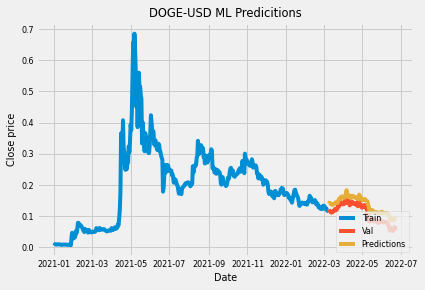

In [22]:
if __name__ == "__main__":
    main()